##Step 1: Install and Import Dependencies

In [ ]:
# !pip uninstall -y transformers tokenizers


In [ ]:
### Step 1: Install and Import Dependencies
!pip install transformers peft torch datasets accelerate pandas scikit-learn transformer_heads


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 45.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 54.7 MB/s eta 0:00:00


In [ ]:
!pip install numpy==1.26.4


In [ ]:
import os
import torch
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from transformers import AutoConfig, GemmaForSequenceClassification, GemmaModel, AutoTokenizer, Trainer, TrainingArguments
from datasets import Dataset, DatasetDict
from transformer_heads import HeadConfig, load_headed
from transformer_heads.model.model import model_type_map
from transformer_heads.util.helpers import DataCollatorWithPadding
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.utils import resample
from tqdm import tqdm
model_type_map["gemma2"] = ("model", GemmaModel)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##*Step* 2: Load Tokenizer and Model

In [ ]:
### Step 2: Load Tokenizer and Model
MODEL_NAME = "google/gemma-2-2b-it"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

tokenizer_config.json:   0%|          | 0.00/47.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

In [ ]:
# Ensure tokenizer has a padding token
if tokenizer.pad_token_id is None:
    tokenizer.pad_token = tokenizer.eos_token

Step 3: Define File Paths for Datasets

In [ ]:
### Step 3: Define File Paths for Cyberbullying Dataset

DATASETS_PATH = "/content/drive/MyDrive/Datasets/"
CB_FILE_PATH = DATASETS_PATH + "/cb_multi_labeled_balanced.csv"

AGG_DATASETS = ["D1", "D2", "D3", "D4", "D5"]

In [ ]:
### Step 4: Load Dataset
cb_df = pd.read_csv(CB_FILE_PATH)
cb_df = cb_df.rename(columns={"text": "text", "label": "label"})
cb_df['task'] = 'cyberbullying'

In [ ]:
agg_data = {}
for dataset in AGG_DATASETS:
    agg_data[dataset] = {}
    dataset_path = os.path.join(DATASETS_PATH, dataset)
    for filename in os.listdir(dataset_path):
        filepath = os.path.join(dataset_path, filename)
        if "train" in filename.lower():
            agg_data[dataset]["train"] = pd.read_csv(filepath)
        elif "test" in filename.lower():
            agg_data[dataset]["test"] = pd.read_csv(filepath)
        else:
            agg_data[dataset]["val"] = pd.read_csv(filepath)

In [ ]:
def preprocess_data(data):
    processed_data = {}
    for dataset_name, dataset_data in data.items():
        processed_data[dataset_name] = {}
        for split_name, df in dataset_data.items():
            new_df = df.rename(columns={
                'Sentence': 'text',
                'tweet': 'text',
                'Label': 'label',
                'aggression': 'label'
            })
            new_df = new_df[['text', 'label']]
            new_df['task'] = 'aggression'

            processed_data[dataset_name][split_name] = new_df

    return processed_data

agg_data = preprocess_data(agg_data)


for dataset_name, dataset in agg_data.items():
  for split_name, df in dataset.items():
      print(f"Dataset: {dataset_name}, Split: {split_name}")
      print(df.head())

Dataset: D1, Split: test
                                                text  label        task
0  (Hold regular town hall/ Chaupals) @MASK Modi ...      0  aggression
1  In Bihar. East & West Champaran. The land of f...      0  aggression
2  The people of India gave these parties the opp...      1  aggression
3  When Rahul Gandhi tore the copy of Ordinance h...      2  aggression
4  BJP's high-pitch negative propaganda (like the...      1  aggression
Dataset: D1, Split: train
                                                text  label        task
0  "Asked if these files of historic value were s...      0  aggression
1  I have to say this. Without a civilian governm...      0  aggression
2  Ladies and Gentlemen This man wants to get awa...      2  aggression
3  Just curious - are the BJP leaders sitting on ...      1  aggression
4  US President Barack Obama congratulates @MASK ...      0  aggression
Dataset: D1, Split: val
                                                text  label  

In [ ]:
# Check for missing values
print(cb_df.isnull().sum())

text     0
label    0
task     0
dtype: int64


In [ ]:
# Define prompts
cb_prompt = "Classify the given text into one of four categories:\n0. Ethnicity/Race - Cyberbullying related to ethnicity or race.\n1. Gender/Sexual - Cyberbullying based on gender or sexual identity.\n2. Religion - Cyberbullying related to religious beliefs or identity.\n3. Not Cyberbullying - The text does not contain cyberbullying content.\nText: "

agg_prompt = """You are a strict text classifier. Your task is to classify the given text into one of three categories:

0: Not Aggressive
- Facts or neutral information
- Genuine questions/discussion
- Positive or helpful comments

1: Covertly Aggressive
- Sarcasm with negative intent
- Using "air quotes" mockingly
- Implying criticism through questions
- False politeness hiding negativity

2: Overtly Aggressive
- Direct insults/threats
- Hostile demands
- Clear anger/hatred

 **Instructions:**
    - **DO NOT** provide any explanation.
    - **DO NOT** add extra text or notes.
    - **DO NOT** rephrase the label.
    - **ONLY return one of these exact labels either 0, 1, or 2:

Text: """

In [ ]:
# Function to preprocess text
def preprocess_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'http\S+|www.\S+', '', text)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return  text

In [ ]:
# Apply preprocessing
cb_df['text'] = cb_df['text'].apply(preprocess_text)
cb_df['text'] = cb_prompt + cb_df['text']

In [ ]:
for dataset_name, dataset in agg_data.items():
    for split_name, df in dataset.items():
        df['text'] = df['text'].apply(preprocess_text)
        df['text'] = agg_prompt + df['text']

In [ ]:
# Mapping text labels to numeric labels (correct for training)
CB_LABELS = {"ethnicity/race": 0,
             "gender/sexual": 1,
             "religion": 2,
             "not_cyberbullying": 3
             }
cb_df["label"] = cb_df["label"].map(CB_LABELS)


In [ ]:
# Display processed data
cb_df.head()

,text,label,task
0,Classify the given text into one of four categ...,0,cyberbullying
1,Classify the given text into one of four categ...,3,cyberbullying
2,Classify the given text into one of four categ...,0,cyberbullying
3,Classify the given text into one of four categ...,2,cyberbullying
4,Classify the given text into one of four categ...,2,cyberbullying


In [ ]:
### Tokenization and Data Preparation
from sklearn.model_selection import train_test_split

cb_train_df, cb_test_dev_df = train_test_split(cb_df, test_size=0.25, random_state=42)

cb_dev_df = cb_test_dev_df.sample(n=2000, random_state=42)
cb_test_df = cb_test_dev_df.drop(cb_dev_df.index)


In [ ]:
# Get minimum class count
min_count = cb_train_df['label'].value_counts().min()

cb_balanced_train_dfs = [resample(cb_train_df[cb_train_df['label'] == lbl], replace=False, n_samples=min_count, random_state=42)
                       for lbl in cb_train_df['label'].unique()]
cb_balanced_train_df = pd.concat(cb_balanced_train_dfs).sample(frac=1, random_state=42).reset_index(drop=True)

print("Balanced Label Distribution:\n", cb_balanced_train_df['label'].value_counts())

Balanced Label Distribution:
 label
0    12030
1    12030
2    12030
3    12030
Name: count, dtype: int64


In [ ]:
# prompt: combine teh datasets in agg_data

agg_combined_data = {}
for split in ["train", "test", "val"]:
    agg_combined_data[split] = pd.DataFrame()
    for dataset_name, dataset in agg_data.items():
        if split in dataset:
            agg_combined_data[split] = pd.concat([agg_combined_data[split], dataset[split]])

for split_name, df in agg_combined_data.items():
    print(f"Combined Split: {split_name}")
    print(df.head())
    print(df.info())


Combined Split: train
                                                text  label        task
0  You are a strict text classifier. Your task is...      0  aggression
1  You are a strict text classifier. Your task is...      0  aggression
2  You are a strict text classifier. Your task is...      2  aggression
3  You are a strict text classifier. Your task is...      1  aggression
4  You are a strict text classifier. Your task is...      0  aggression
<class 'pandas.core.frame.DataFrame'>
Index: 34856 entries, 0 to 11998
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    34856 non-null  object
 1   label   34856 non-null  int64 
 2   task    34856 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.1+ MB
None
Combined Split: test
                                                text  label        task
0  You are a strict text classifier. Your task is...      0  aggression
1  You are a strict text classifier. Your t

In [ ]:

min_count_agg = agg_combined_data['train']['label'].value_counts().min()

# Resample each class in the combined training data
agg_balanced_train_dfs = [resample(agg_combined_data['train'][agg_combined_data['train']['label'] == lbl],
                                   replace=False, n_samples=min_count_agg, random_state=42)
                          for lbl in agg_combined_data['train']['label'].unique()]
agg_balanced_train_df = pd.concat(agg_balanced_train_dfs).sample(frac=1, random_state=42).reset_index(drop=True)

# Check new label distribution for the combined training data
print("Balanced Label Distribution (Aggregated Train Data):\n", agg_balanced_train_df['label'].value_counts())


Balanced Label Distribution (Aggregated Train Data):
 label
0    7350
1    7350
2    7350
Name: count, dtype: int64


In [ ]:

# Combine Cyberbullying datasets
train_df = pd.concat([cb_train_df, agg_combined_data["train"]])
dev_df = pd.concat([cb_dev_df, agg_combined_data["val"]])
test_df = pd.concat([cb_test_df, agg_combined_data["test"]])
balanced_train_df = pd.concat([cb_balanced_train_df, agg_balanced_train_df])

# Display info for combined datasets
print("Combined Train Data:")
print(train_df.info())
print("\nCombined Dev Data:")
print(dev_df.info())
print("\nCombined Test Data:")
print(test_df.info())
print("\nBalanced Train Data:")
print(balanced_train_df.info())


Combined Train Data:
<class 'pandas.core.frame.DataFrame'>
Index: 109848 entries, 60132 to 11998
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    109848 non-null  object
 1   label   109848 non-null  int64 
 2   task    109848 non-null  object
dtypes: int64(1), object(2)
memory usage: 3.4+ MB
None

Combined Dev Data:
<class 'pandas.core.frame.DataFrame'>
Index: 6258 entries, 79072 to 1500
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    6258 non-null   object
 1   label   6258 non-null   int64 
 2   task    6258 non-null   object
dtypes: int64(1), object(2)
memory usage: 195.6+ KB
None

Combined Test Data:
<class 'pandas.core.frame.DataFrame'>
Index: 28456 entries, 33965 to 1499
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    28456 non-null  object
 1   label   28456 non-null  int64

In [ ]:


train_texts, train_labels, train_tasks = balanced_train_df["text"].tolist(), balanced_train_df["label"].tolist(), balanced_train_df["task"].tolist()
dev_texts, dev_labels, dev_tasks = dev_df["text"].tolist(), dev_df["label"].tolist(), dev_df["task"].tolist()
test_texts, test_labels, test_tasks = test_df["text"].tolist(), test_df["label"].tolist(), test_df["task"].tolist()

print(f"✅ Training set size: {len(train_texts)}")
print(f"✅ Development set size: {len(dev_texts)} (should be exactly 2000)")
print(f"✅ Test set size: {len(test_texts)}")

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
dev_encodings = tokenizer(dev_texts, truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=512)

dataset = DatasetDict({
    "train": Dataset.from_dict({
        "input_ids": train_encodings["input_ids"],
        "attention_mask": train_encodings["attention_mask"],
        "label": train_labels,
        'task': train_tasks,
    }),
    "validation": Dataset.from_dict({
        "input_ids": dev_encodings["input_ids"],
        "attention_mask": dev_encodings["attention_mask"],
        "label": dev_labels,
        'task': dev_tasks,
    }),
    "test": Dataset.from_dict({
        "input_ids": test_encodings["input_ids"],
        "attention_mask": test_encodings["attention_mask"],
        "label": test_labels,
        'task': test_tasks,
    })
})

✅ Training set size: 70170
✅ Development set size: 6258 (should be exactly 2000)
✅ Test set size: 28456


In [ ]:
# Apply tokenization and filtering
for split in ["train", "validation"]:
    dataset[split] = dataset[split].filter(lambda example: len(example["input_ids"]) > 10)
    dataset[split] = dataset[split].shuffle()

dataset.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "label", 'task'],
)

Filter:   0%|          | 0/70170 [00:00<?, ? examples/s]

Filter:   0%|          | 0/6258 [00:00<?, ? examples/s]

In [ ]:
from transformers.modeling_outputs import SequenceClassifierOutput
import torch.nn as nn

class WrappedModel(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.base_model = base_model
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, input_ids, attention_mask, labels=None, task=None, *args, **kwargs):
        output = self.base_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            task=task,
            *args,
            **kwargs
        )
        if not task or len(task) != 1:
          raise ValueError(f"task have incorrect shape {task}")
        logits = output.preds_by_head[task[0]]

        if logits.dim() == 3:
            logits = logits[:, 0, :]

        loss = self.loss_fn(logits, labels) if labels is not None else None
        return SequenceClassifierOutput(loss=loss, logits=logits)

    def gradient_checkpointing_enable(self, *args, **kwargs):
        self.base_model.gradient_checkpointing_enable(*args, **kwargs)



In [ ]:
from transformers import AutoConfig
config = AutoConfig.from_pretrained(MODEL_NAME)
print(config.hidden_size)


config.json:   0%|          | 0.00/838 [00:00<?, ?B/s]

2304


In [ ]:
in_size=config.hidden_size


##*Step* 5: Define Transformer Heads for Cyberbullying

In [ ]:
# Define model head and load base model

config = AutoConfig.from_pretrained(MODEL_NAME)

head_configs = [
    HeadConfig(name="cyberbullying",
               in_size=config.hidden_size,
               num_outputs=4,
               layer_hook=-1,
               loss_fct="cross_entropy"),

    HeadConfig(name="aggression",
               in_size=config.hidden_size,
               num_outputs=3,
               layer_hook=-1,
               loss_fct="cross_entropy")
]


base_model = load_headed(
    GemmaForSequenceClassification,
    MODEL_NAME,
    head_configs=head_configs,
    device_map=None,
    quantization_config=None,

)


base_model.gradient_checkpointing_enable()

# Wrap the model
model = WrappedModel(base_model)


You are using a model of type gemma2 to instantiate a model of type gemma. This is not supported for all configurations of models and can yield errors.


model.safetensors.index.json:   0%|          | 0.00/24.2k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/241M [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of TransformerWithHeads were not initialized from the model checkpoint at google/gemma-2-2b-it and are newly initialized: ['heads.aggression.lins.0.weight', 'heads.cyberbullying.lins.0.weight', 'score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


##Step 6: Define Training Arguments and Trainer




In [ ]:

from transformers import TrainingArguments


training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="no",
    learning_rate = 5e-02,
    weight_decay = 0.0,
    adam_beta1 = 0.9,
    adam_beta2 = 0.999,
    adam_epsilon = 1e-08,
    max_grad_norm = 1.0,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    num_train_epochs=6,
    logging_dir="./logs",
    report_to="none",
    gradient_checkpointing=True,
    bf16=True,
    fp16=False,
    remove_unused_columns=False,
    ddp_find_unused_parameters=False,
)


In [ ]:
import transformers
print(transformers.__version__)

## Step:8 Add the compute_metrics function

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="macro"),
        "precision": precision_score(labels, preds, average="macro"),
        "recall": recall_score(labels, preds, average="macro"),
    }


##Step:9 Train the model

In [ ]:
from transformers import default_data_collator

def multitask_data_collator(features):
    batch = default_data_collator(features)

    if "task" in features[0]:
        batch["task"] = [f["task"] for f in features]

    return batch

In [ ]:
# Clear GPU memory before training
import torch
torch.cuda.empty_cache()

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    compute_metrics=compute_metrics,
    data_collator=multitask_data_collator,
)


# Start Training
trainer.train()


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,144.709600,24.862494,0.509428,0.531873,0.638677,0.588391
2,100.072700,95.272430,0.620006,0.565286,0.800055,0.576202
3,71.315700,119.864380,0.463087,0.446565,0.796954,0.526439
4,48.465400,33.910393,0.648610,0.613217,0.754258,0.626483
5,29.899000,20.258699,0.554171,0.573575,0.750533,0.593037
6,13.689900,7.938920,0.658677,0.675671,0.683592,0.669342


/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


TrainOutput(global_step=421020, training_loss=68.02537735737019, metrics={'train_runtime': 24958.9224, 'train_samples_per_second': 16.869, 'train_steps_per_second': 16.869, 'total_flos': 0.0, 'train_loss': 68.02537735737019, 'epoch': 6.0})

## Evaluate on Test Set

Filter:   0%|          | 0/28456 [00:00<?, ? examples/s]


📊 Test Set Metrics:
Accuracy:  0.9105
Precision: 0.8872
Recall:    0.9174
F1 Score:  0.9003

Cyberbullying Classification Report:
                   precision    recall  f1-score   support

   ethnicity/race       0.81      0.91      0.86      3954
    gender/sexual       0.93      0.93      0.93      3849
not_cyberbullying       0.98      0.90      0.94     11543
         religion       0.83      0.93      0.88      3652

         accuracy                           0.91     22998
        macro avg       0.89      0.92      0.90     22998
     weighted avg       0.92      0.91      0.91     22998



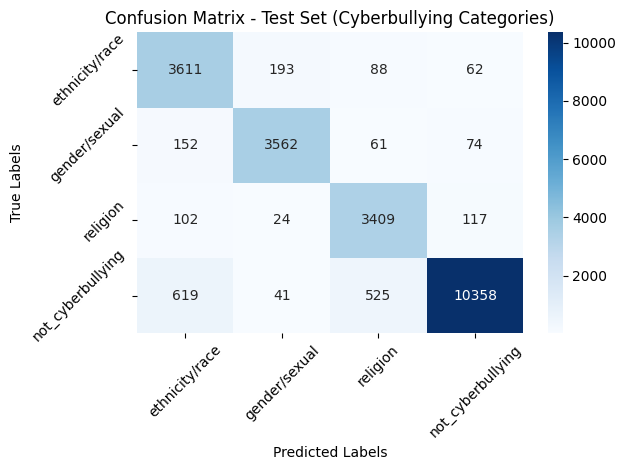

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

INV_CB_LABELS = {v: k for k, v in CB_LABELS.items()}

cb_dataset = dataset["test"].filter(lambda example: example["task"] == 'cyberbullying')
predictions = trainer.predict(cb_dataset)
logits = predictions[0]
cb_test_labels = np.array(cb_dataset["label"])
predicted_labels = logits.argmax(axis=-1)

predicted_text_labels = [INV_CB_LABELS[label] for label in predicted_labels]
true_text_labels = [INV_CB_LABELS[label] for label in cb_test_labels]

print("\n📊 Test Set Metrics:")
print(f"Accuracy:  {accuracy_score(cb_test_labels, predicted_labels):.4f}")
print(f"Precision: {precision_score(cb_test_labels, predicted_labels, average='macro'):.4f}")
print(f"Recall:    {recall_score(cb_test_labels, predicted_labels, average='macro'):.4f}")
print(f"F1 Score:  {f1_score(cb_test_labels, predicted_labels, average='macro'):.4f}")

print("\nCyberbullying Classification Report:")
print(classification_report(true_text_labels, predicted_text_labels))

conf_matrix = confusion_matrix(true_text_labels, predicted_text_labels, labels=list(CB_LABELS.keys()))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=CB_LABELS.keys(), yticklabels=CB_LABELS.keys())

plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - Test Set (Cyberbullying Categories)")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()


Filter:   0%|          | 0/28456 [00:00<?, ? examples/s]


📊 Test Set Metrics:
Accuracy:  0.5348
Precision: 0.5111
Recall:    0.5095
F1 Score:  0.5097

Aggression Classification Report:
                     precision    recall  f1-score   support

covertly aggressive       0.42      0.47      0.44      1668
     not aggressive       0.66      0.62      0.64      2585
 overtly aggressive       0.45      0.44      0.45      1205

           accuracy                           0.53      5458
          macro avg       0.51      0.51      0.51      5458
       weighted avg       0.54      0.53      0.54      5458



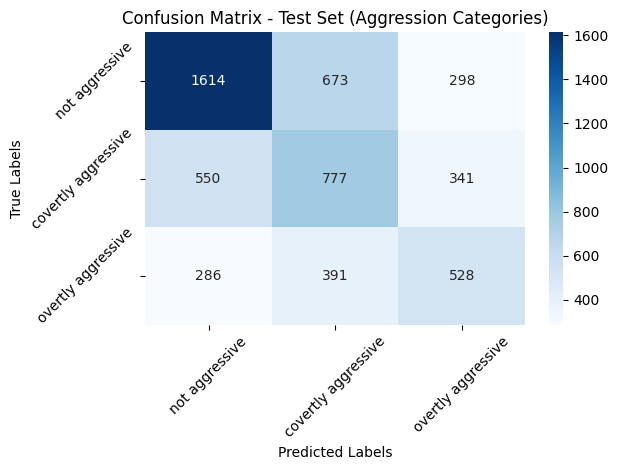

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

AGG_LABELS = {0: "not aggressive", 1: "covertly aggressive", 2: "overtly aggressive"}

agg_dataset = dataset["test"].filter(lambda example: example["task"] == 'aggression')
predictions = trainer.predict(agg_dataset)
logits = predictions[0]
agg_test_labels = np.array(agg_dataset["label"])
predicted_labels = logits.argmax(axis=-1)

predicted_text_labels = [AGG_LABELS[label] for label in predicted_labels]
true_text_labels = [AGG_LABELS[label] for label in agg_test_labels]

print("\n📊 Test Set Metrics:")
print(f"Accuracy:  {accuracy_score(agg_test_labels, predicted_labels):.4f}")
print(f"Precision: {precision_score(agg_test_labels, predicted_labels, average='macro'):.4f}")
print(f"Recall:    {recall_score(agg_test_labels, predicted_labels, average='macro'):.4f}")
print(f"F1 Score:  {f1_score(agg_test_labels, predicted_labels, average='macro'):.4f}")

print("\nAggression Classification Report:")
print(classification_report(true_text_labels, predicted_text_labels))

conf_matrix = confusion_matrix(true_text_labels, predicted_text_labels, labels=list(AGG_LABELS.values()))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=AGG_LABELS.values(), yticklabels=AGG_LABELS.values())

plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - Test Set (Aggression Categories)")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()
